In [1]:
import string
import sys
from collections import deque

import pandas as pd
import numpy as np
import altair as alt
alt.renderers.enable('mimetype')

from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import warnings

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor

from sklearn.utils import shuffle

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [3]:
train_df = pd.read_csv("data/train.csv")

In [4]:
train_df.set_index('PassengerId', inplace=True)

In [5]:
train_df = shuffle(train_df)

In [6]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
111,0,1,"Porter, Mr. Walter Chamberlain",male,47.00,0,0,110465,52.0000,C110,S
271,0,1,"Cairns, Mr. Alexander",male,NaN,0,0,113798,31.0000,NaN,S
572,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.00,2,0,11769,51.4792,C101,S
756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
762,0,3,"Nirva, Mr. Iisakki Antino Aijo",male,41.00,0,0,SOTON/O2 3101272,7.1250,NaN,S


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 111 to 870
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [8]:
train_df.nunique()

Survived      2
Pclass        3
Name        891
Sex           2
Age          88
SibSp         7
Parch         7
Ticket      681
Fare        248
Cabin       147
Embarked      3
dtype: int64

# Data Wrangling

In [9]:
train_df['Survived'] = train_df['Survived'].astype(str)

In [10]:
train_df.loc[train_df['Pclass'] == 1, 'Pclass'] = "1st"
train_df.loc[train_df['Pclass'] == 2, 'Pclass'] = "2nd"
train_df.loc[train_df['Pclass'] == 3, 'Pclass'] = "3rd"
train_df['missing_Cabin'] = train_df['Cabin'].isna()
train_df['missing_Age'] = train_df['Age'].isna()
train_df['missing_Fare'] = train_df['Fare'].isna()
train_df.loc[train_df['Cabin'].isna(), 'Cabin'] = "missing"

train_df['Cabin'] = train_df['Cabin'].str.replace("^A{1}.*", "A")
train_df['Cabin'] = train_df['Cabin'].str.replace("^B{1}.*", "B")
train_df['Cabin'] = train_df['Cabin'].str.replace("^C{1}.*", "C")
train_df['Cabin'] = train_df['Cabin'].str.replace("^D{1}.*", "D")
train_df['Cabin'] = train_df['Cabin'].str.replace("^E{1}.*", "E")
train_df['Cabin'] = train_df['Cabin'].str.replace("^F{1}.*", "F")
train_df['Cabin'] = train_df['Cabin'].str.replace("^G{1}.*", "G")
train_df["n_Family"] = train_df["SibSp"] + train_df["Parch"] + 1

train_df['Age_bin'] = pd.cut(train_df['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])

train_df['Fare_bin'] = pd.cut(train_df['Fare'], bins=[0, 7.91, 14.45, 31, 120], labels=['Low_fare','median_fare', 'Average_fare','high_fare'])

train_df.loc[train_df['Age'].isna(), 'Age'] = "missing"
train_df.loc[train_df['Fare'].isna(), 'Fare'] = "missing"

train_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,missing_Cabin,missing_Age,missing_Fare,n_Family,Age_bin,Fare_bin
PassengerId,,,,,,,,,,,,,,,,,
111,0,1st,"Porter, Mr. Walter Chamberlain",male,47.0,0,0,110465,52.0,C,S,False,False,False,1,Elder,high_fare
271,0,1st,"Cairns, Mr. Alexander",male,missing,0,0,113798,31.0,missing,S,True,True,False,1,NaN,Average_fare
572,1,1st,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0,2,0,11769,51.4792,C,S,False,False,False,3,Elder,high_fare
756,1,2nd,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5,missing,S,True,False,False,3,Children,Average_fare
762,0,3rd,"Nirva, Mr. Iisakki Antino Aijo",male,41.0,0,0,SOTON/O2 3101272,7.125,missing,S,True,False,False,1,Elder,Low_fare
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,0,3rd,"Rush, Mr. Alfred George John",male,16.0,0,0,A/4. 20589,8.05,missing,S,True,False,False,1,Teenage,median_fare
448,1,1st,"Seward, Mr. Frederic Kimber",male,34.0,0,0,113794,26.55,missing,S,True,False,False,1,Adult,Average_fare
326,1,1st,"Young, Miss. Marie Grice",female,36.0,0,0,PC 17760,135.6333,C,C,False,False,False,1,Adult,NaN


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 111 to 870
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Survived       891 non-null    object  
 1   Pclass         891 non-null    object  
 2   Name           891 non-null    object  
 3   Sex            891 non-null    object  
 4   Age            891 non-null    object  
 5   SibSp          891 non-null    int64   
 6   Parch          891 non-null    int64   
 7   Ticket         891 non-null    object  
 8   Fare           891 non-null    object  
 9   Cabin          891 non-null    object  
 10  Embarked       889 non-null    object  
 11  missing_Cabin  891 non-null    bool    
 12  missing_Age    891 non-null    bool    
 13  missing_Fare   891 non-null    bool    
 14  n_Family       891 non-null    int64   
 15  Age_bin        714 non-null    category
 16  Fare_bin       838 non-null    category
dtypes: bool(3), category(2), int64(3)

# EDA

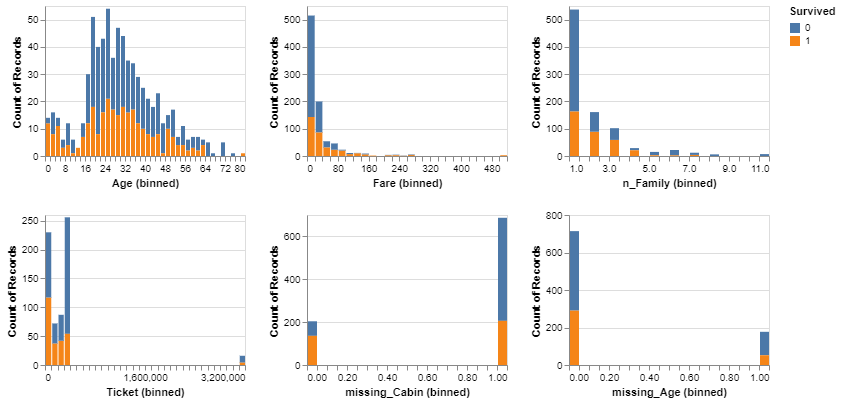

In [12]:
alt.Chart(train_df).mark_bar().encode(
    alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=40)),
    y='count()',
    fill='Survived'
).properties(
    width=200,
    height=150
).repeat(
    ['Age', 'Fare', 'n_Family', 'Ticket', 'missing_Cabin', 'missing_Age'],
    columns=3
)

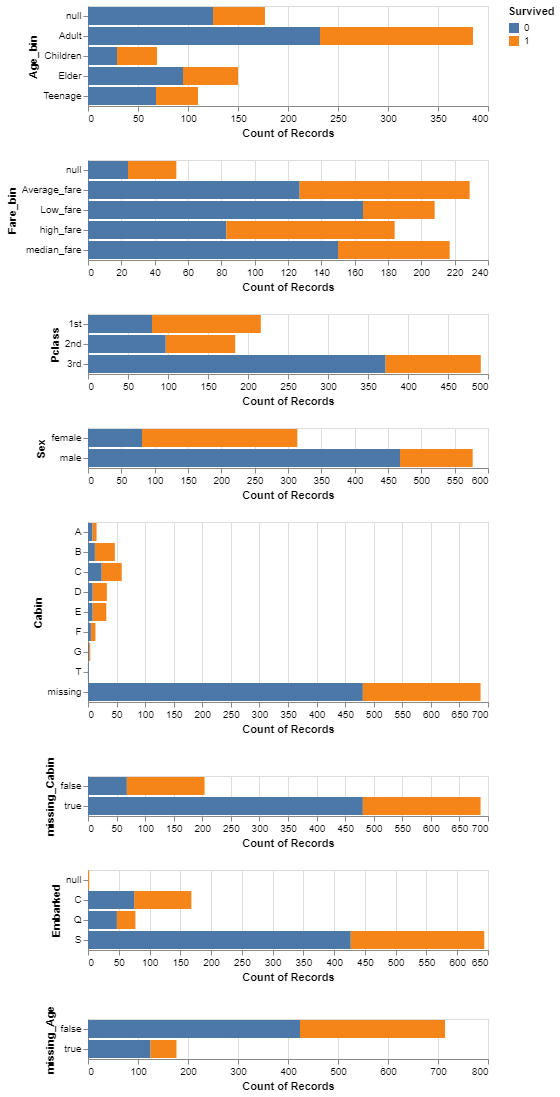

In [13]:
#Pclass, Sex, Cabin, Embarked

plot_age_bin = alt.Chart(train_df).mark_bar().encode(
    y='Age_bin',
    x='count()',
    fill='Survived'
)

plot_fare_bin = alt.Chart(train_df).mark_bar().encode(
    y='Fare_bin',
    x='count()',
    fill='Survived'
)

plot_pclass = alt.Chart(train_df).mark_bar().encode(
    y='Pclass',
    x='count()',
    fill='Survived'
)
plot_sex = alt.Chart(train_df).mark_bar().encode(
    y='Sex',
    x='count()',
    fill='Survived'
)
plot_cabin = alt.Chart(train_df).mark_bar().encode(
    x='count()',
    y='Cabin',
    fill='Survived'
)
plot_missing_cabin = alt.Chart(train_df).mark_bar().encode(
    x='count()',
    y='missing_Cabin',
    fill='Survived'
)
plot_embarked = alt.Chart(train_df).mark_bar().encode(
    y='Embarked',
    x='count()',
    fill='Survived'
)
plot_missing_age = alt.Chart(train_df).mark_bar().encode(
    x='count()',
    y='missing_Age',
    fill='Survived'
)

plot_age_bin & plot_fare_bin & plot_pclass & plot_sex & plot_cabin & plot_missing_cabin & plot_embarked & plot_missing_age

In [14]:
X_train, y_train = train_df.drop(columns=['Survived']), train_df['Survived']

# Feature types

In [15]:
#"0" in list(X_train['Parch'])
#X_train['Parch'].nunique()

In [16]:
numeric_features = ["n_Family"]
binary_features = ["Sex", "missing_Cabin", "missing_Age", "missing_Fare"]
ordinal_features = ["Pclass"]
ordering_ordinal = [
    ["3rd", "2nd", "1st"]
]
ticket_features = "Ticket"
categorical_features = ["Cabin", "Embarked", "Age_bin", "Fare_bin"]
drop_features = ["Name", "SibSp", "Parch", "Age", "Fare"]

In [17]:
ct = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy='median'), StandardScaler()),
        numeric_features
    ),
    (
        OneHotEncoder(drop="if_binary", dtype=int, sparse=False, handle_unknown="ignore"), 
        binary_features
    ),
    (
        OrdinalEncoder(categories=ordering_ordinal),
        ordinal_features
    ),
    (
        CountVectorizer(ngram_range=(1, 3)),
        ticket_features
    ),
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(handle_unknown="ignore")
        ), categorical_features
    ),
    ("drop", drop_features)
)



In [18]:
results = {}

In [19]:
pipe_dummy = make_pipeline(ct, DummyClassifier())

In [20]:
results["Dummy"] = mean_std_cross_val_scores(
    pipe_dummy, X_train, y_train, return_train_score=True
)

In [21]:
pd.DataFrame(results)

,Dummy
fit_time,0.023 (+/- 0.003)
score_time,0.011 (+/- 0.002)
test_score,0.616 (+/- 0.003)
train_score,0.616 (+/- 0.001)


# ML Models

In [22]:
pipe_dt = make_pipeline(ct, DecisionTreeClassifier(random_state=123))
pipe_svc = make_pipeline(ct, SVC(random_state=123))
pipe_rf = make_pipeline(ct, RandomForestClassifier(random_state=123))
pipe_xgb = make_pipeline(ct, XGBClassifier(random_state=123, verbosity=0))
pipe_lgbm = make_pipeline(ct, LGBMClassifier(random_state=123))
pipe_catb = make_pipeline(ct, CatBoostClassifier(random_state=123, verbose=0))

In [23]:
models = {
    "decision_tree": pipe_dt,
    "SVC": pipe_svc,
    "random_forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catb
}

In [24]:
for (name, model) in models.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True
    )

C:\Users\johnw\miniconda3\envs\573\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\johnw\miniconda3\envs\573\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\johnw\miniconda3\envs\573\lib\site-packages\xgboost\sklearn.py:88

In [25]:
pd.DataFrame(results)

,Dummy,decision_tree,SVC,random_forest,XGBoost,LightGBM,CatBoost
fit_time,0.023 (+/- 0.003),0.027 (+/- 0.003),0.045 (+/- 0.004),0.243 (+/- 0.020),0.176 (+/- 0.005),0.067 (+/- 0.006),4.645 (+/- 0.654)
score_time,0.011 (+/- 0.002),0.008 (+/- 0.001),0.016 (+/- 0.003),0.021 (+/- 0.002),0.015 (+/- 0.001),0.013 (+/- 0.001),0.013 (+/- 0.002)
test_score,0.616 (+/- 0.003),0.822 (+/- 0.014),0.815 (+/- 0.017),0.804 (+/- 0.022),0.813 (+/- 0.011),0.825 (+/- 0.022),0.831 (+/- 0.019)
train_score,0.616 (+/- 0.001),0.996 (+/- 0.001),0.859 (+/- 0.012),0.996 (+/- 0.001),0.916 (+/- 0.003),0.891 (+/- 0.003),0.868 (+/- 0.006)


## For Feature Importances

In [26]:
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['n_Family']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Sex', 'missing_Cabin

In [27]:
ticket_column = pipe_rf.named_steps["columntransformer"].named_transformers_["countvectorizer"].get_feature_names_out(ticket_features).tolist()

In [28]:
catagorical_columns = pipe_rf.named_steps["columntransformer"].named_transformers_["pipeline-2"].named_steps["onehotencoder"].get_feature_names_out(categorical_features).tolist()

In [29]:
columns = numeric_features + binary_features + ordinal_features + ticket_column + catagorical_columns

## Top 20 Features

In [30]:
pd.Series(pipe_rf.named_steps["randomforestclassifier"].feature_importances_, columns).sort_values(ascending=False).head(20)

Sex                      0.177647
n_Family                 0.050477
Pclass                   0.043143
Cabin_missing            0.027006
missing_Cabin            0.024055
Age_bin_Children         0.018148
Age_bin_Adult            0.016343
Fare_bin_Average_fare    0.013527
Embarked_S               0.013112
missing_Age              0.012831
Age_bin_Elder            0.012708
Fare_bin_high_fare       0.012233
Embarked_C               0.011025
Fare_bin_Low_fare        0.010990
1601                     0.008941
Age_bin_Teenage          0.008094
Fare_bin_median_fare     0.008086
Cabin_E                  0.008060
Cabin_B                  0.007038
pc                       0.006385
dtype: float64

In [31]:
import matplotlib.pyplot as plt

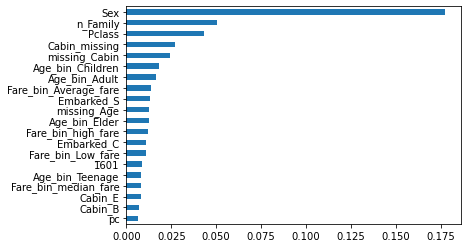

In [32]:
top20 = pd.Series(pipe_rf.named_steps["randomforestclassifier"].feature_importances_, columns).sort_values(ascending=False).head(20)
top20.plot.barh().invert_yaxis()
plt.show()

## Prepare prediction on X_test

In [33]:
X_test = pd.read_csv("data/test.csv")
X_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [34]:
X_test.loc[X_test['Pclass'] == 1, 'Pclass'] = "1st"
X_test.loc[X_test['Pclass'] == 2, 'Pclass'] = "2nd"
X_test.loc[X_test['Pclass'] == 3, 'Pclass'] = "3rd"
X_test['missing_Cabin'] = X_test['Cabin'].isna()
X_test['missing_Age'] = X_test['Age'].isna()
X_test['missing_Fare'] = X_test['Fare'].isna()
X_test.loc[X_test['Cabin'].isna(), 'Cabin'] = "missing"

X_test['Cabin'] = X_test['Cabin'].str.replace("^A{1}.*", "A")
X_test['Cabin'] = X_test['Cabin'].str.replace("^B{1}.*", "B")
X_test['Cabin'] = X_test['Cabin'].str.replace("^C{1}.*", "C")
X_test['Cabin'] = X_test['Cabin'].str.replace("^D{1}.*", "D")
X_test['Cabin'] = X_test['Cabin'].str.replace("^E{1}.*", "E")
X_test['Cabin'] = X_test['Cabin'].str.replace("^F{1}.*", "F")
X_test['Cabin'] = X_test['Cabin'].str.replace("^G{1}.*", "G")
X_test["n_Family"] = X_test["SibSp"] + X_test["Parch"] + 1

X_test['Age_bin'] = pd.cut(
    X_test['Age'], 
    bins=[0,12,20,40,120], 
    labels=['Children','Teenage','Adult','Elder'])

X_test['Fare_bin'] = pd.cut(
    X_test['Fare'], 
    bins=[0, 7.91, 14.45, 31, 120], 
    labels=['Low_fare','median_fare', 'Average_fare','high_fare'])

X_test.loc[X_test['Age'].isna(), 'Age'] = "missing"
X_test.loc[X_test['Fare'].isna(), 'Fare'] = "missing"

X_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,missing_Cabin,missing_Age,missing_Fare,n_Family,Age_bin,Fare_bin
0,892,3rd,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,missing,Q,True,False,False,1,Adult,Low_fare
1,893,3rd,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0,missing,S,True,False,False,2,Elder,Low_fare
2,894,2nd,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,missing,Q,True,False,False,1,Elder,median_fare
3,895,3rd,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,missing,S,True,False,False,1,Adult,median_fare
4,896,3rd,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,missing,S,True,False,False,3,Adult,median_fare
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3rd,"Spector, Mr. Woolf",male,missing,0,0,A.5. 3236,8.05,missing,S,True,True,False,1,NaN,median_fare
414,1306,1st,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9,C,C,False,False,False,1,Adult,high_fare
415,1307,3rd,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.25,missing,S,True,False,False,1,Adult,Low_fare
416,1308,3rd,"Ware, Mr. Frederick",male,missing,0,0,359309,8.05,missing,S,True,True,False,1,NaN,median_fare


In [35]:
pipe_catb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['n_Family']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Sex', 'missing_Cabin

In [36]:
X_test["missing_Fare"].value_counts()   # Since True is not included in X_train, "handle_unknown=True" was applied

False    417
True       1
Name: missing_Fare, dtype: int64

In [37]:
X_train["missing_Fare"].value_counts()

False    891
Name: missing_Fare, dtype: int64

In [38]:
prediction = pipe_catb.predict(X_test)

C:\Users\johnw\miniconda3\envs\573\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [39]:
X_test = X_test.drop(
    columns = [
        "Pclass", "Name", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", 
        "Cabin", "Embarked", "missing_Cabin", "missing_Age", "n_Family", 
        "Age_bin", "Fare_bin", "missing_Fare"
    ]
)
X_test

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [40]:
X_test["Survived"] = prediction
X_test

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [41]:
X_test.to_csv("titanic_result_Catboost_final.csv", encoding='utf-8', index=False)